In [1]:
import numpy as np
from numpy import pi
import pyvista as pv
from pyvista import examples
from scipy.linalg import kron, eig
from string import ascii_lowercase
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['text.usetex'] = True

In [2]:
dr=[190.0/255.0,30.0/255.0,45.0/255.0]
dy=[255.0/255.0,213.0/255.0,58.0/255.0]
dg=[175.0/255.0,169.0/255.0,97.0/255.0] # Durham green
db=[0,174.0/255.0,239.0/255.0]
dp=[104.0/255.0,36.0/255.0,109.0/255.0]
di=[0.0/255.0,42.0/255.0,65.0/255.0] # Durham ink	
dpi=[203.0/255.0,168.0/255.0,177.0/255.0] #  Durham pink 
ds=[218.0/255.0,205.0/255.0,162.0/255.0] # Durham stone
dsk=[165.0/255.0,200.0/255.0,208.0/255.0] # Durham sky

In [3]:
def Dissipator(sigma):
    d = np.shape(sigma)[0]
    sigma = np.mat(sigma)
    I = np.eye(d)
    I = np.mat(I)
    return np.mat(kron(np.conj(sigma),sigma) - 0.5*kron(I,np.conj(sigma.T)*sigma) - 0.5*kron((np.conj(sigma.T)*sigma).T,I))

def Trajectory(Omega1,Omega2,Delta,delta,Gamma1,Gamma2,tmax):
    r=3.0 #radius of the Bloch sphere
    
    #define quantum states
    g1 = np.array([1,0,0])
    g1 = np.mat(g1)
    g2 = np.array([0,1,0])
    g2 = np.mat(g2)
    e = np.array([0,0,1])
    e = np.mat(e)
    
    #define matrices
    sigma1 = g1.T*e
    sigma2 = g2.T*e
    sigmax = np.array([[0,1,0],[1,0,0],[0,0,0]])
    sigmax = np.mat(sigmax)
    sigmay = np.array([[0,-1j,0],[1j,0,0],[0,0,0]])
    sigmay = np.mat(sigmay)
    sigmaz = np.array([[1,0,0],[0,-1,0],[0,0,0]])
    sigmaz = np.mat(sigmaz)
    sigma0 = np.array([[0,0,0],[0,0,0],[0,0,1]])
    sigma0 = np.mat(sigma0)
    
    #define Hamiltonian
    I3 = np.eye(3)
    I3 = np.mat(I3)
    H_a = Delta*g1.T*g1 + (Delta-delta)*g2.T*g2
    H_af = 0.5*Omega1*(sigma1 + np.conj(sigma1.T)) + 0.5*Omega2*(sigma2 + np.conj(sigma2.T))
    H = H_a + H_af
    #define superoperator
    H_eff = -1j*np.mat(kron(I3,H) - kron(np.conj(H.T),I3)) 
    L_eff = Gamma1*Dissipator(sigma1) + Gamma2*Dissipator(sigma2)
    S = H_eff+L_eff 
    evals, evecs = eig(S)
    evecs = np.mat(evecs)
    
    #define time parameters
    numt = 1000
    t = np.linspace(0,tmax,numt)
    dt = t[1] - t[0]
    
    #define initial state 
    rho0 = np.mat(np.zeros((9,1)))
    rho0[0,0] = 1.0
    
    #define Bloch vectors
    u1 = np.zeros(numt)
    v1 = np.zeros(numt)
    w1 = np.zeros(numt)
    u2 = np.zeros(numt)
    v2 = np.zeros(numt)
    w2 = np.zeros(numt)
    pe = np.zeros(numt)
    pg1 = np.zeros(numt)
    pg2 = np.zeros(numt)
    
    for i in range(numt):
        rho=evecs*np.mat(np.diag(np.exp(evals*t[i])))*np.linalg.inv(evecs)*rho0
        pg1[i] = np.real(rho[0,0])
        pg2[i] = np.real(rho[4,0])
        pe[i] = np.real(rho[8,0])
        DM = rho.reshape(3,3)
        u1[i] = np.real(np.trace(sigmax*DM))
        v1[i] = np.real(np.trace(sigmay*DM))
        w1[i] = np.real(np.trace(sigmaz*DM))
        r2 = np.real(np.trace(sigma0*DM))
        if(r2==1):
            u2[i] = r2*np.cos(0.5*pi*r2)
            v2[i] = r2*np.cos(0.5*pi*r2)
            w2[i] = r2*np.sin(0.5*pi*r2)
        else:
            u2[i] = r2*np.cos(0.5*pi*r2)*(np.real(rho[2,0])/np.abs(rho[2,0])) if np.abs!=0 else 0
            v2[i] = r2*np.cos(0.5*pi*r2)*(np.imag(rho[2,0])/np.abs(rho[2,0])) if np.abs!=0 else 0
            w2[i] = r2*np.sin(0.5*pi*r2)
        
    return r*np.column_stack((u1, v1, w1)), r*np.column_stack((u2, v2, w2)), np.column_stack((pg1, pg2, pe))


def STIRAP(Omega1,Omega2,Delta,delta,t1,t2,tau1,tau2,tmax):
    r=3.0 #radius of the Bloch sphere
    
    #define quantum states
    g1 = np.array([1,0,0])
    g1 = np.mat(g1)
    g2 = np.array([0,1,0])
    g2 = np.mat(g2)
    e = np.array([0,0,1])
    e = np.mat(e)
    
    #define matrices
    sigma1 = g1.T*e
    sigma2 = g2.T*e
    sigmax = np.array([[0,1,0],[1,0,0],[0,0,0]])
    sigmax = np.mat(sigmax)
    sigmay = np.array([[0,-1j,0],[1j,0,0],[0,0,0]])
    sigmay = np.mat(sigmay)
    sigmaz = np.array([[1,0,0],[0,-1,0],[0,0,0]])
    sigmaz = np.mat(sigmaz)
    sigma0 = np.array([[0,0,0],[0,0,0],[0,0,1]])
    sigma0 = np.mat(sigma0)
    
    #define Rabi pulse 1 and 2
    numt = 1000
    t = np.linspace(0,tmax,numt)
    dt = t[1] - t[0]
    E1 = np.abs(np.real(Omega1*np.exp((-1/(2*tau1**2))*(t-t1)**2))) #Gaussian pulse 
    E2 = np.abs(np.real(Omega1*np.exp((-1/(2*tau2**2))*(t-t2)**2))) #Gaussian pulse 
    
    #define Hamiltonian 
    H = np.zeros([numt,3,3])
    H = np.zeros([numt,3,3])
    H[:,0,0] = Delta
    H[:,1,1] = Delta-delta
    H[:,0,2] = 0.5*E1
    H[:,1,2] = 0.5*E2
    H[:,2,0] = 0.5*np.conj(E1)
    H[:,2,1] = 0.5*np.conj(E2)
    
    #define initial states 
    psi_0 = np.zeros((3,1)) 
    psi_0[0] = 1.0 
    psi_0 = np.mat(psi_0)
    
    #define Bloch vectors
    u1 = np.zeros(numt)
    v1 = np.zeros(numt)
    w1 = np.zeros(numt)
    u2 = np.zeros(numt)
    v2 = np.zeros(numt)
    w2 = np.zeros(numt)
    pe = np.zeros(numt)
    pg1 = np.zeros(numt)
    pg2 = np.zeros(numt)
    
    psi_all = psi_0
    
    for i in range(numt):
        evals, evecs = eig(H[i,:,:])
        evecs = np.mat(evecs)
        psi_all = evecs*np.mat(np.diag(np.exp(-1j*evals*dt)))*np.linalg.inv(evecs)*psi_all
        rho_all = psi_all*np.conj(psi_all.T)
        pg1[i] = np.real(rho_all[0,0])
        pg2[i] = np.real(rho_all[1,1])
        pe[i] = np.real(rho_all[2,2])
        u1[i] = np.real(np.trace(sigmax*rho_all))
        v1[i] = np.real(np.trace(sigmay*rho_all))
        w1[i] = np.real(np.trace(sigmaz*rho_all))
        r2 = np.real(np.trace(sigma0*rho_all))
        if(r2==1):
            u2[i] = r2*np.cos(0.5*pi*r2)
            v2[i] = r2*np.cos(0.5*pi*r2)
            w2[i] = r2*np.sin(0.5*pi*r2)
        else:
            u2[i] = r2*np.cos(0.5*pi*r2)*(np.real(rho_all[0,2])/np.abs(rho_all[0,2])) if np.abs!=0 else 0
            v2[i] = r2*np.cos(0.5*pi*r2)*(np.imag(rho_all[0,2])/np.abs(rho_all[0,2])) if np.abs!=0 else 0
            w2[i] = r2*np.sin(0.5*pi*r2)
            
    
    return r*np.column_stack((u1, v1, w1)), r*np.column_stack((u2, v2, w2)), np.column_stack((pg1, pg2, pe)), np.column_stack((E1,E2))
        
    
class EIT:
    
    def __init__(self,Omega1,Omega2,Gamma1,Gamma2,delta,Dmax,t):
        self.Omega1 = Omega1
        self.Omega2 = Omega2
        self.Gamma1 = Gamma1
        self.Gamma2 = Gamma2
        self.delta = delta
        self.Dmax = Dmax 
        self.time = t
        
    def susceptibility(self,showgraph=False):
        #define quantum states
        g1 = np.array([1,0,0])
        g1 = np.mat(g1)
        g2 = np.array([0,1,0])
        g2 = np.mat(g2)
        e = np.array([0,0,1])
        e = np.mat(e)
        I3 = np.eye(3)
        I3 = np.mat(I3)
        #define matrices
        sigma1 = g1.T*e
        sigma2 = g2.T*e
        #define Linblad super operator
        L_eff = self.Gamma1*Dissipator(sigma1) + self.Gamma2*Dissipator(sigma2)
        #define Delta array
        numd = 1000
        Delta = np.linspace(-1*self.Dmax,self.Dmax,numd)
        #define array for containing susceptibility
        rhoba_r = np.zeros(numd)
        rhoba_i = np.zeros(numd)
        #define initial states
        rho0 = np.mat(np.zeros((9,1)))
        rho0[0,0] = 1.0
        
        #Hamiltoniam evolution
        for i in range(numd):
            H = 0.5*np.array([[0,0,self.Omega1],[0,-2*Delta[i],self.Omega2],[np.conj(self.Omega1),np.conj(self.Omega2),-2*(Delta[i]-self.delta)]])
            H_eff = -1j*np.mat(kron(I3,H) - kron(np.conj(H.T),I3))
            S = H_eff+L_eff 
            evals, evecs = eig(S)
            evecs = np.mat(evecs)
            rho_all = evecs*np.mat(np.diag(np.exp(evals*self.time)))*np.linalg.inv(evecs)*rho0
            rhoba_r[i] = np.real(rho_all[2])
            rhoba_i[i] = -1*np.imag(rho_all[2])
        
        if(showgraph):
            plt.figure()
            plt.plot(Delta,rhoba_r,label=r"Real part of $\chi$")
            plt.plot(Delta,rhoba_i,label=r"Imaginary part of $\chi$")
            plt.ylabel(r"Susceptibility $\chi$")
            plt.xlabel(r"Detuning ($\Delta$)")
            plt.legend()
            #plt.savefig('EITchi.png',dpi=120)
            plt.show()
        
        return np.column_stack((rhoba_r, rhoba_i))
    
    def getstates(self,Delta=0,showgraph=False):
        r = 3.0
        #define quantum states
        g1 = np.array([1,0,0])
        g1 = np.mat(g1)
        g2 = np.array([0,1,0])
        g2 = np.mat(g2)
        e = np.array([0,0,1])
        e = np.mat(e)
        #define matrices
        sigma1 = g1.T*e
        sigma2 = g2.T*e
        sigmax = np.array([[0,1,0],[1,0,0],[0,0,0]])
        sigmax = np.mat(sigmax)
        sigmay = np.array([[0,-1j,0],[1j,0,0],[0,0,0]])
        sigmay = np.mat(sigmay)
        sigmaz = np.array([[1,0,0],[0,-1,0],[0,0,0]])
        sigmaz = np.mat(sigmaz)
        sigma0 = np.array([[0,0,0],[0,0,0],[0,0,1]])
        sigma0 = np.mat(sigma0)
        I3 = np.eye(3)
        I3 = np.mat(I3)
        #define Linblad super operator
        L_eff = self.Gamma1*Dissipator(sigma1) + self.Gamma2*Dissipator(sigma2)
        #define Delta array
        numt = 1000
        t = np.linspace(0,self.time,numt)
        #define array for containing susceptibility
        u1 = np.zeros(numt)
        v1 = np.zeros(numt)
        w1 = np.zeros(numt)
        u2 = np.zeros(numt)
        v2 = np.zeros(numt)
        w2 = np.zeros(numt)
        pe = np.zeros(numt)
        pg1 = np.zeros(numt)
        pg2 = np.zeros(numt)
        #define initial states
        rho0 = np.mat(np.zeros((9,1)))
        rho0[0,0] = 1.0
        
        #Hamiltoniam evolution
        if(Delta==0):
            H = 0.5*np.array([[0,0,self.Omega1],[0,-2*self.delta,self.Omega2],[np.conj(self.Omega1),np.conj(self.Omega2),-2*(self.delta-self.delta)]])
        else:
            H = 0.5*np.array([[0,0,self.Omega1],[0,-2*Delta,self.Omega2],[np.conj(self.Omega1),np.conj(self.Omega2),-2*(Delta-self.delta)]])
        
        H_eff = -1j*np.mat(kron(I3,H) - kron(np.conj(H.T),I3))
        S = H_eff+L_eff 
        evals, evecs = eig(S)
        evecs = np.mat(evecs)
        
        for i in range(numt):
            rho=evecs*np.mat(np.diag(np.exp(evals*t[i])))*np.linalg.inv(evecs)*rho0
            pg1[i] = np.real(rho[0,0])
            pg2[i] = np.real(rho[4,0])
            pe[i] = np.real(rho[8,0])
            DM = rho.reshape(3,3)
            u1[i] = np.real(np.trace(sigmax*DM))
            v1[i] = np.real(np.trace(sigmay*DM))
            w1[i] = np.real(np.trace(sigmaz*DM))
            r2 = np.real(np.trace(sigma0*DM))
            if(r2==1):
                u2[i] = r2*np.cos(0.5*pi*r2)
                v2[i] = r2*np.cos(0.5*pi*r2)
                w2[i] = r2*np.sin(0.5*pi*r2)
            else:
                u2[i] = r2*np.cos(0.5*pi*r2)*(np.real(rho[2,0])/np.abs(rho[2,0])) if np.abs!=0 else 0
                v2[i] = r2*np.cos(0.5*pi*r2)*(np.imag(rho[2,0])/np.abs(rho[2,0])) if np.abs!=0 else 0
                w2[i] = r2*np.sin(0.5*pi*r2)
                
        if(showgraph):
            plt.figure()
            plt.plot(t,pg1,label=r'$|g_1\rangle$')
            plt.plot(t,pg2,label=r'$|g_2\rangle$')
            plt.plot(t,pe,label=r'$|e\rangle$')
            plt.ylabel(r"Population")
            plt.xlabel(r"Time ($t$)")
            plt.legend()
            #plt.savefig('EITstates2.png',dpi=120)
            plt.show()
        
        return r*np.column_stack((u1, v1, w1)), r*np.column_stack((u2, v2, w2)), np.column_stack((pg1, pg2, pe))
            
        
    
    

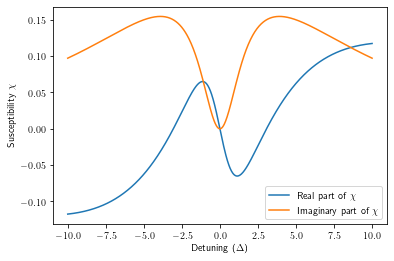

array([[-0.11740891,  0.09716599],
       [-0.11736273,  0.09736306],
       [-0.11731574,  0.0975605 ],
       ...,
       [ 0.11731574,  0.0975605 ],
       [ 0.11736273,  0.09736306],
       [ 0.11740891,  0.09716599]])

In [4]:
eit = EIT(Omega1=5,Omega2=5,Gamma1=10,Gamma2=5,delta=0.0,Dmax=10.0,t=40.0)
eit.susceptibility(showgraph=True)

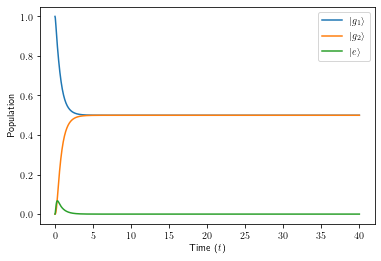

(array([[-1.26981758e-15,  0.00000000e+00,  3.00000000e+00],
        [-2.71009406e-02, -8.32667268e-17,  2.97438403e+00],
        [-9.72578217e-02, -8.32667268e-17,  2.91152990e+00],
        ...,
        [-3.00000000e+00,  1.75078566e-16,  2.33146835e-15],
        [-3.00000000e+00,  1.75078566e-16,  2.33146835e-15],
        [-3.00000000e+00,  1.75078566e-16,  2.33146835e-15]]),
 array([[-1.88547006e-17, -0.00000000e+00,  1.86139226e-34],
        [ 7.20737285e-18, -2.22839224e-02,  2.60034623e-04],
        [ 1.49119917e-17, -6.62364216e-02,  2.29947280e-03],
        ...,
        [ 2.53263662e-17,  4.43227731e-17,  1.36446335e-33],
        [ 2.53263662e-17,  4.43227731e-17,  1.36446335e-33],
        [ 2.53263662e-17,  4.43227731e-17,  1.36446335e-33]]),
 array([[ 1.00000000e+00,  2.22044605e-16, -6.28490020e-18],
        [ 9.92016432e-01,  5.55088255e-04,  7.42847986e-03],
        [ 9.74208929e-01,  3.69896328e-03,  2.20921080e-02],
        ...,
        [ 5.00000000e-01,  5.00000000e-01,

In [5]:
eit.getstates(Delta=0.0,showgraph=True)

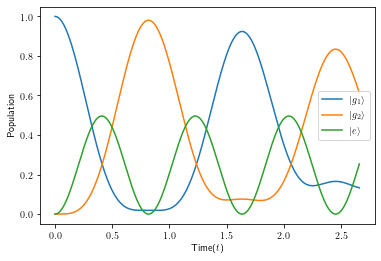

In [79]:
#Stumulated Raman transition with adiabatic elimination
nt = 1000
tm = 2.66
t = np.linspace(0,tm,nt)
bloch = Trajectory(Omega1=8.0,Omega2=8.0,Delta=1.01,delta=0.0,Gamma1=0,Gamma2=0,tmax=1.8)
plt.figure()
plt.plot(t,bloch[2][:,0],label=r'$|g_1\rangle$')
plt.plot(t,bloch[2][:,1],label=r'$|g_2\rangle$')
plt.plot(t,bloch[2][:,2],label=r'$|e\rangle$')
plt.ylabel("Population")
plt.xlabel(r"Time($t$)")
plt.legend()
#plt.savefig('GraphStimRaDelta.png',dpi=120)
plt.show()

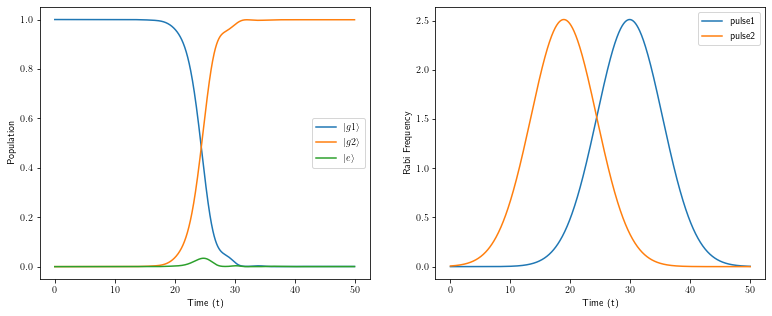

In [184]:
#STIRAP
nt = 1000
tm1 = 50
t = np.linspace(0,tm1,nt)
bloch1 = STIRAP(Omega1=2.51,Omega2=2.51,Delta=0.00,delta=0.00,t1=32.25,t2=20.4,tau1=5.91,tau2=5.91,tmax=53.95)
plt.figure(figsize=(13,5))
plt.subplot(121)
plt.plot(t,bloch1[2][:,0],label=r'$|g1\rangle$')
plt.plot(t,bloch1[2][:,1],label=r'$|g2\rangle$')
plt.plot(t,bloch1[2][:,2],label=r'$|e\rangle$')
plt.ylabel('Population')
plt.xlabel('Time (t)')
plt.legend()
plt.subplot(122)
plt.plot(t,bloch1[3][:,0],label='pulse1')
plt.plot(t,bloch1[3][:,1],label='pulse2')
plt.ylabel('Rabi Frequency')
plt.xlabel('Time (t)')
plt.legend()
#plt.savefig('STIRAPGRAPH.png',dpi=120)
plt.show()

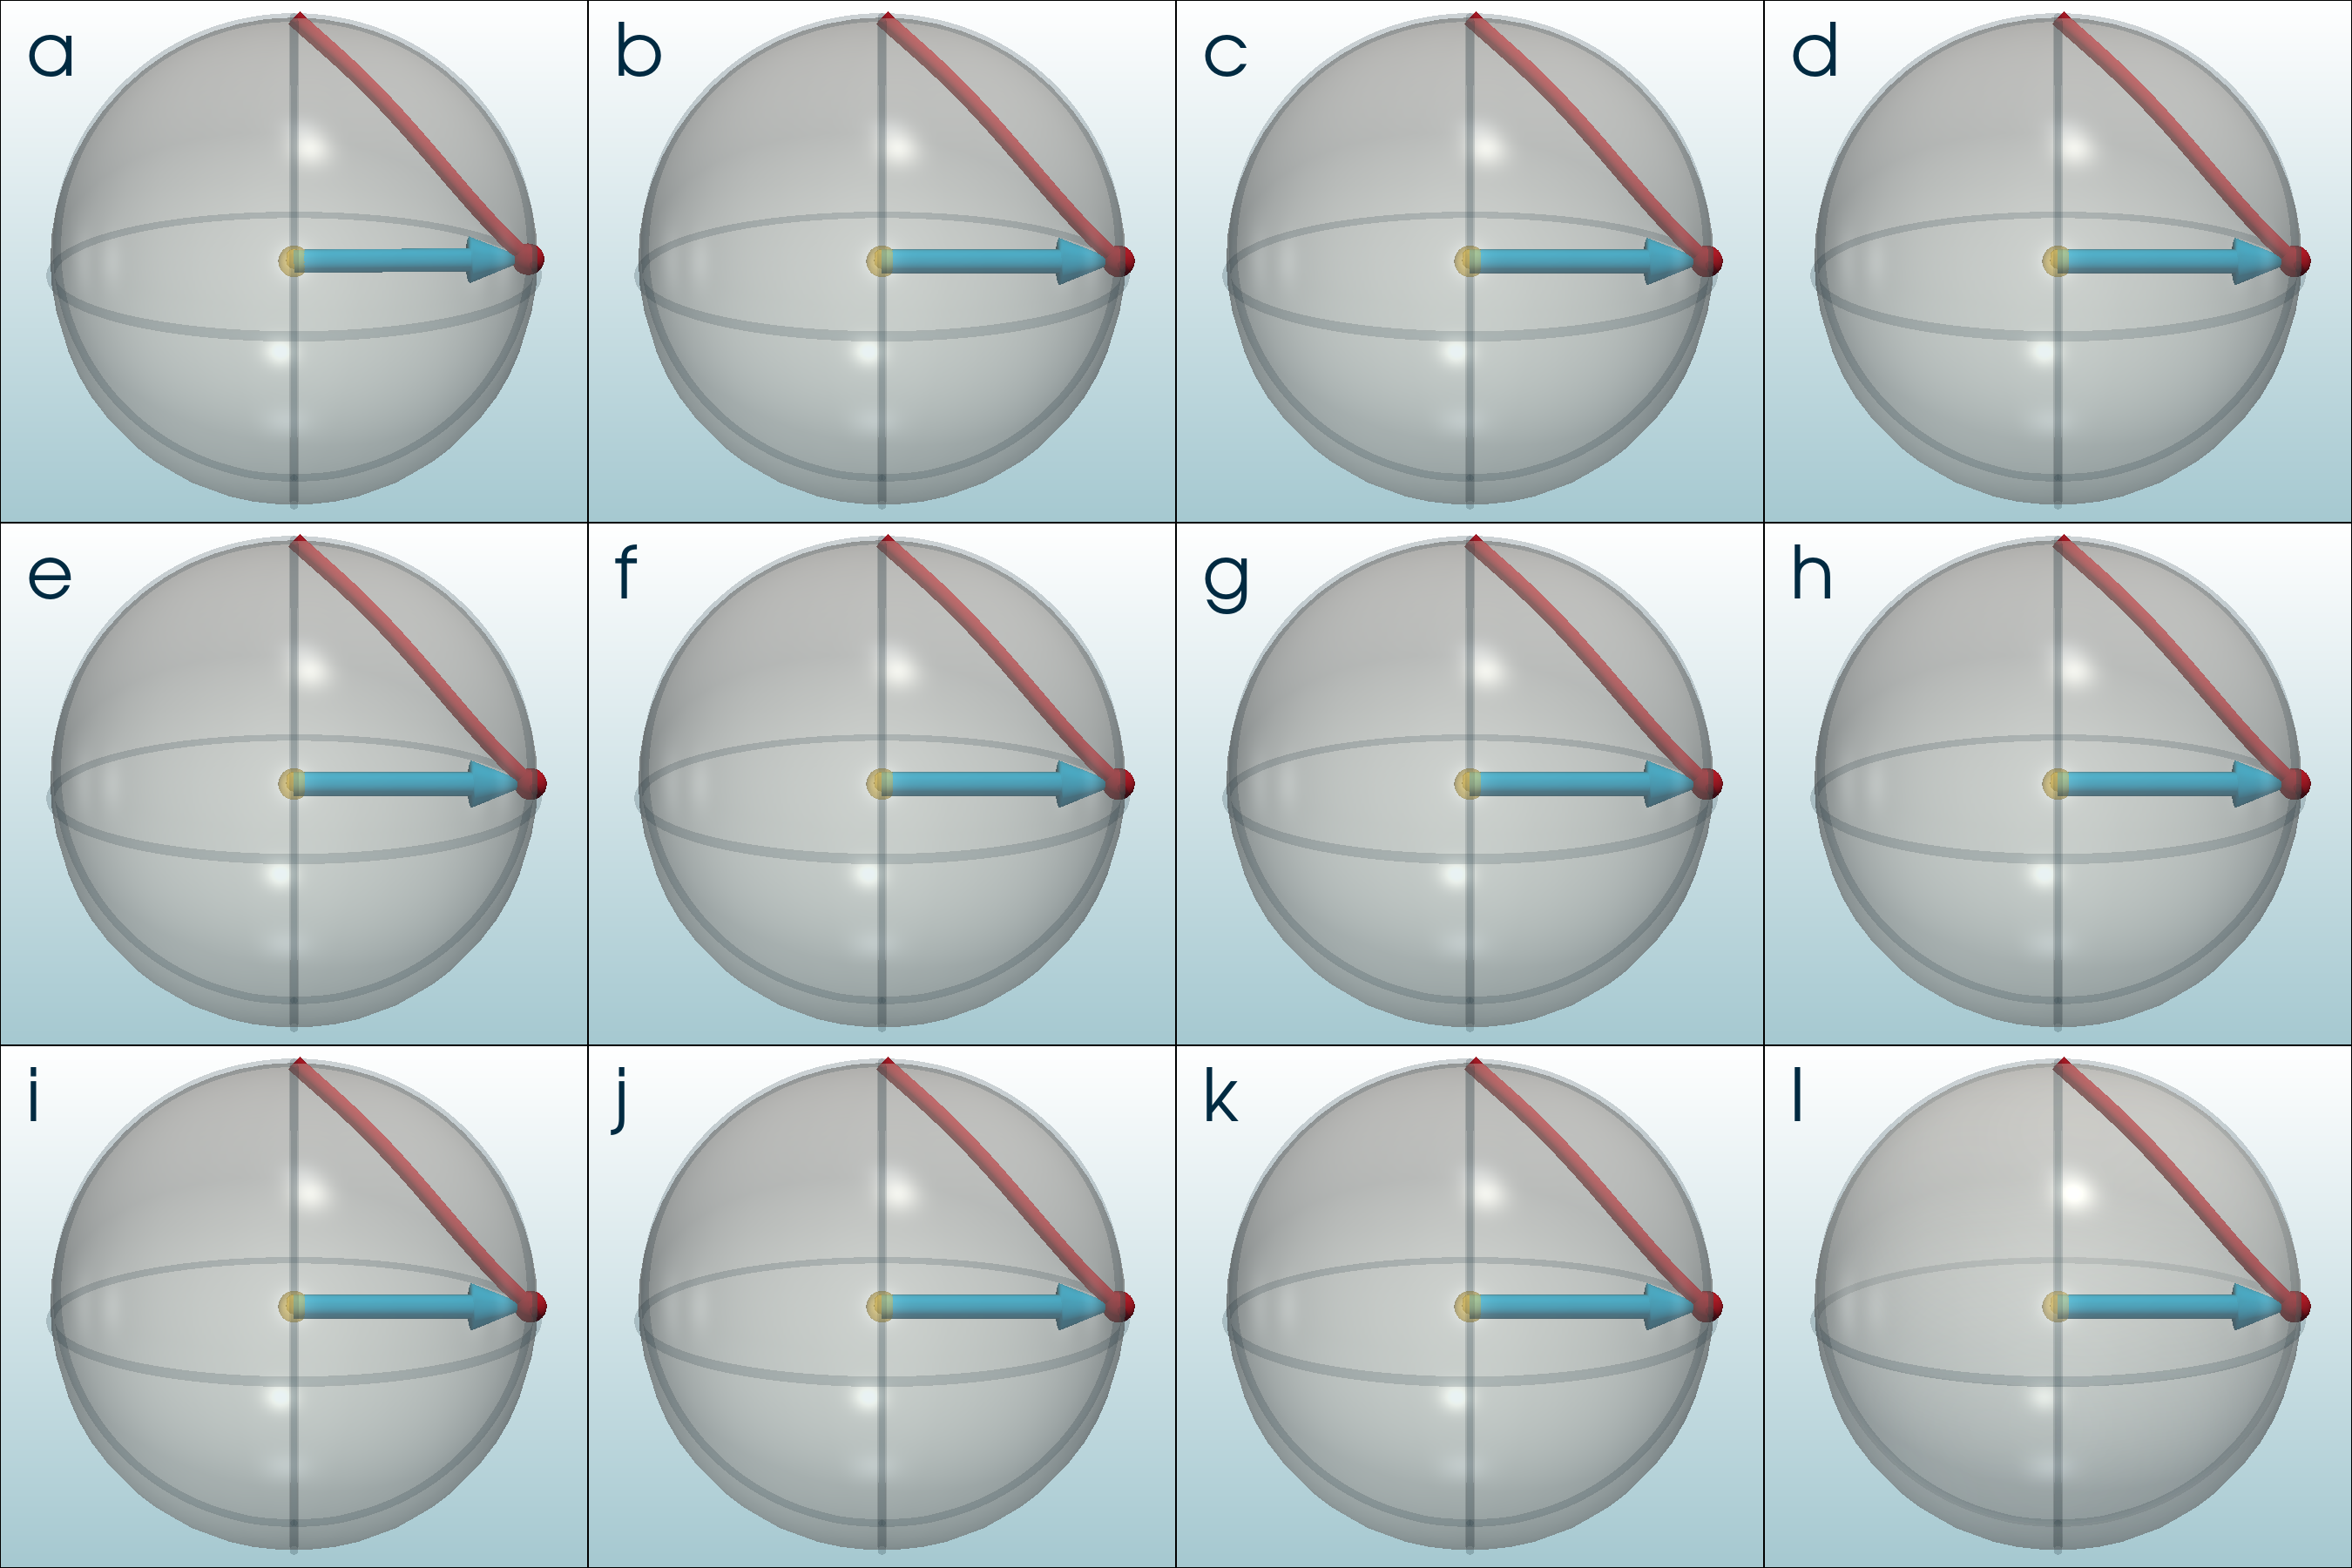

[(0.0, 12.0, 3.0),
 (0.0, 0.0, 0.0),
 (0.0, 0.0, 1.0)]

In [173]:
### Generate Bloch sphere by using pv.Spline for Stimulate Raman Transition with decay process
num=50
theta = np.linspace(-1 * np.pi, 1 * np.pi, num)
r=3.0
phi=0*np.pi/60

z = 0*r * np.cos(theta)
x = r * np.cos(theta)
y = r * np.sin(theta)
rpts=np.column_stack((x, y, z))
spline = pv.Spline(rpts, 1000)
rxy_tube=spline.tube(radius=0.05)

z = r * np.cos(theta)
x = r * np.sin(theta)*np.cos(phi-np.pi/2)
y = r * np.sin(theta)*np.sin(phi-np.pi/2)
rpts=np.column_stack((x, y, z))
spline = pv.Spline(rpts, 1000)
rxz_tube=spline.tube(radius=0.05)

z = r * np.cos(theta)
x = r * np.sin(theta)*np.cos(phi)
y = r * np.sin(theta)*np.sin(phi)
rpts=np.column_stack((x, y, z))
spline = pv.Spline(rpts, 1000)
ryz_tube=spline.tube(radius=0.05)

### Plot spline on Bloch sphere
small=pv.Sphere(center=(0, 0, r), radius=0.2)
big=pv.Sphere(center=(0, 0, 0), radius=r)
sargs = dict(height=0.25, vertical=True, position_x=0.05, position_y=0.05)
res=3

###Generate time for multi plots
numt = 1000
nx=4
ny=3
tt = np.linspace(0,numt,nx*ny+1)

### Spline plots

#Get trajectory 
traj = eit.getstates(Delta=0.0,showgraph=False)

#begin pyvista plot
p = pv.Plotter(shape=(ny,nx), multi_samples=1, window_size=(res*900,res*600))
p.set_background(dsk, top="white")

'''UFO = pv.Light(position=(10, 10, 10), focal_point=(0, 0, 0), color='white')
UFO.positional = True
UFO.cone_angle = 40
UFO.exponent = 1
UFO.intensity = 0.5
UFO.show_actor()
p.add_light(UFO)
'''
k=1
for i in range(0,ny):
    for j in range(0,nx):
        p.subplot(i,j)
        #p.add_mesh(small, opacity=1.0, color=dr, smooth_shading=True)
        p.add_mesh(big, opacity=0.4, color="w", specular=0.85, smooth_shading=True)
#        p.add_mesh(tube,smooth_shading=True,color=dpi)
#        p.add_mesh(tube,smooth_shading=True,scalar_bar_args=sargs)
        
        label=ascii_lowercase[(4*i+j)]
#        p.add_text('$\\vert \\psi\\rangle$',[180.0*res,165.0*res],color=di,font_size=res*14)
        p.add_text(label,[10.0*res,165.0*res],color=di,font_size=res*14)
        p.add_mesh(rxy_tube,opacity=0.1,smooth_shading=True,color=di)
        p.add_mesh(rxz_tube,opacity=0.1,smooth_shading=True,color=di)
        p.add_mesh(ryz_tube,opacity=0.1,smooth_shading=True,color=di)
        
        # Spline1 for vector1
        points1 = traj[0][0:int(tt[k]),:] 
        spline1 = pv.Spline(points1, 1000)
        spline1["scalars"] = np.arange(spline1.n_points)
        tubes1=spline1.tube(radius=0.1)
        #Sline2 for vector2
        points2 = traj[1][0:int(tt[k]),:]
        spline2 = pv.Spline(points2, 1000)
        spline2["scalars"] = np.arange(spline2.n_points)
        tubes2=spline2.tube(radius=0.1)
        
        p.add_mesh(tubes1,color=dr,smooth_shading=True,show_scalar_bar=False)
        ept1=pv.Sphere(center=(points1[-1,:]), radius=0.2)
        p.add_mesh(ept1, opacity=1.0, color=dr, smooth_shading=True)
        arrow=pv.Arrow(start=(0.0, 0.0, 0.0), direction=(points1[-1,:]), tip_length=0.25, tip_radius=0.1, tip_resolution=20, shaft_radius=0.05, shaft_resolution=20, scale=np.sqrt(sum(points1[-1,:]**2)))
        p.add_mesh(arrow, opacity=1.0, color=db, smooth_shading=True)
        
        p.add_mesh(tubes2,color=dy,smooth_shading=True,show_scalar_bar=False)
        ept2=pv.Sphere(center=(points2[-1,:]), radius=0.2)
        p.add_mesh(ept2, opacity=0.5, color=dy, smooth_shading=True)
        arrow=pv.Arrow(start=(0.0, 0.0, 0.0), direction=(points2[-1,:]), tip_length=0.25, tip_radius=0.1, tip_resolution=20, shaft_radius=0.05, shaft_resolution=20, scale=np.sqrt(sum(points2[-1,:]**2)))
        p.add_mesh(arrow, opacity=0.5, color=db, smooth_shading=True)
        
        k += 1
    


#print(points[-1,:])
        
p.enable_depth_peeling(10)
p.link_views()
p.camera_position = [(0.0, 12.0, 3.0),
                     (0.0, 0.0, 0.0),
                     (0.0, 0.0, 0.1)]
#p.camera_position = [(12.0, 0.0, 1.0),(0.0, 0.0, 0.0),(0.1, 0.0, 0.1)]

#p.show(screenshot='EITbloch.png')
p.show()




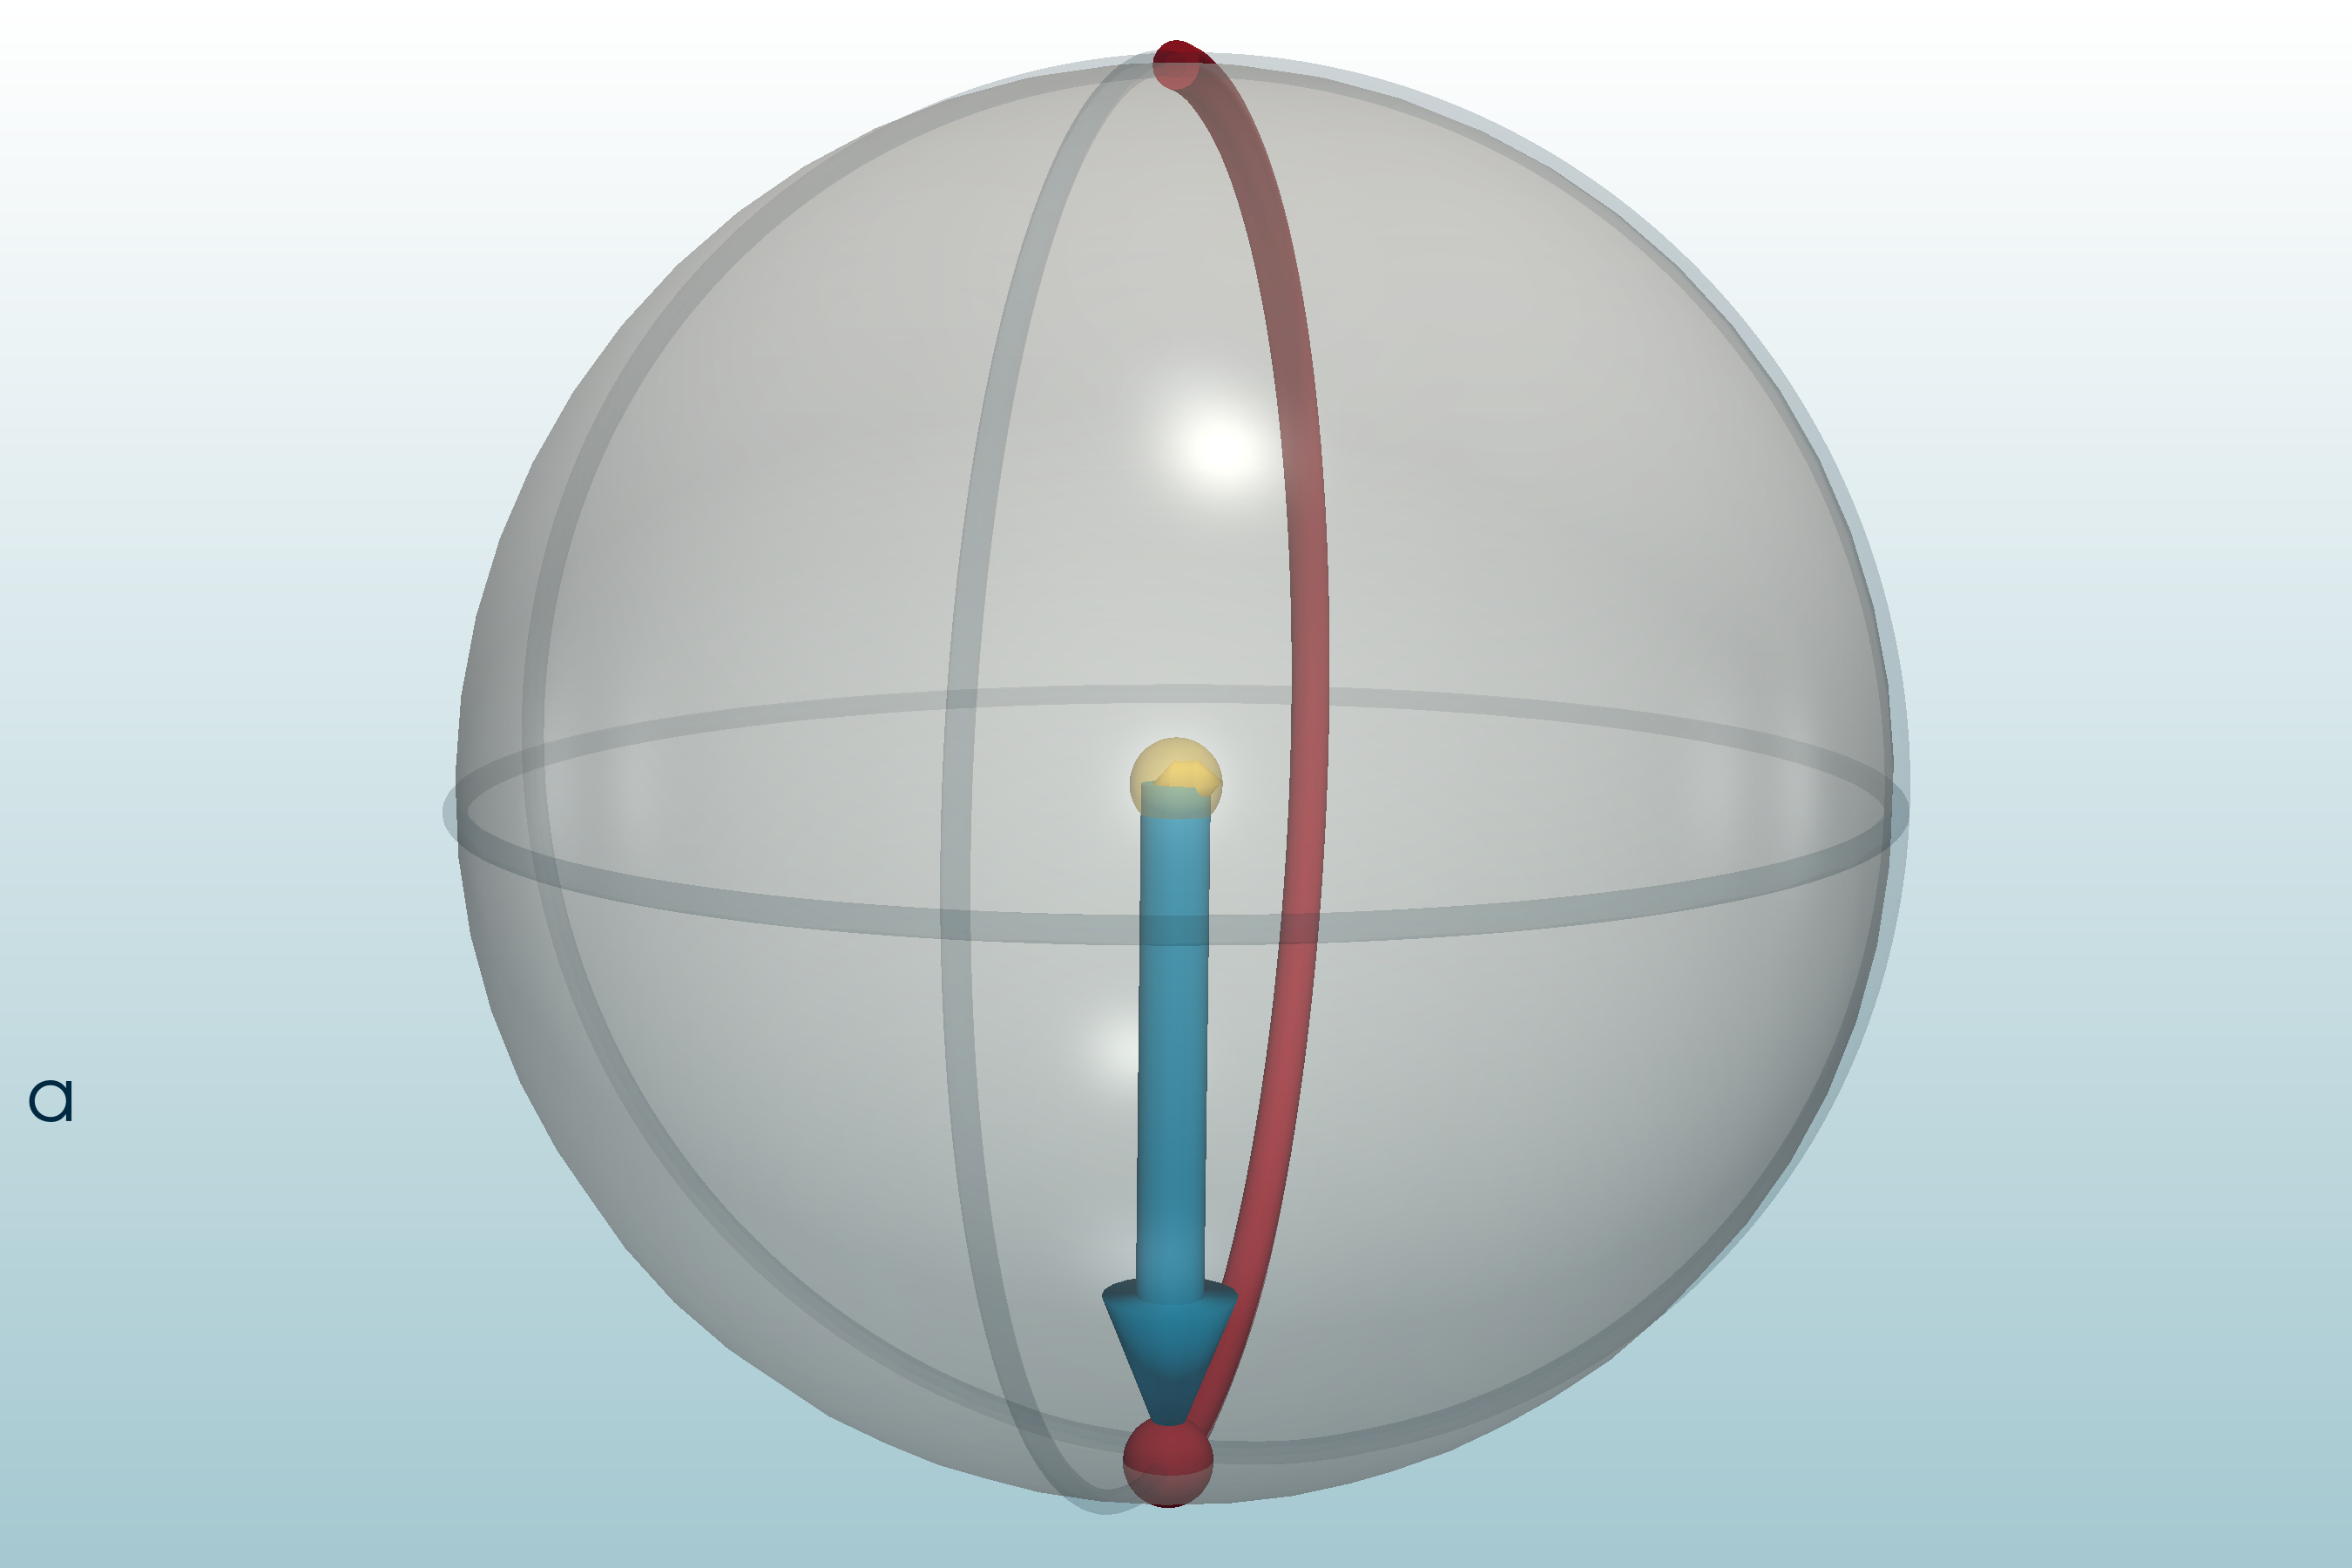

[(12.0, 3.0, 2.0),
 (0.0, 0.0, 0.0),
 (0.0, 0.0, 1.0)]

In [179]:
###STIRAP

#Get trajectory 
#t_max1 = 0.9
traj1 = STIRAP(Omega1=2.51,Omega2=2.51,Delta=0.00,delta=0.00,t1=32.25,t2=20.4,tau1=5.91,tau2=5.91,tmax=53.95)

#begin pyvista plot
p1 = pv.Plotter(multi_samples=1, window_size=(res*900,res*600))
p1.set_background(dsk, top="white")

'''UFO = pv.Light(position=(10, 10, 10), focal_point=(0, 0, 0), color='white')
UFO.positional = True
UFO.cone_angle = 40
UFO.exponent = 1
UFO.intensity = 0.5
UFO.show_actor()
p.add_light(UFO)
'''
kk=1
for i in range(0,1):
    for j in range(0,1):
        #p1.subplot(i,j)
        #p.add_mesh(small, opacity=1.0, color=dr, smooth_shading=True)
        p1.add_mesh(big, opacity=0.4, color="w", specular=0.85, smooth_shading=True)
#        p.add_mesh(tube,smooth_shading=True,color=dpi)
#        p.add_mesh(tube,smooth_shading=True,scalar_bar_args=sargs)
        
        label=ascii_lowercase[(4*i+j)]
#        p.add_text('$\\vert \\psi\\rangle$',[180.0*res,165.0*res],color=di,font_size=res*14)
        p1.add_text(label,[10.0*res,165.0*res],color=di,font_size=res*14)
        p1.add_mesh(rxy_tube,opacity=0.1,smooth_shading=True,color=di)
        p1.add_mesh(rxz_tube,opacity=0.1,smooth_shading=True,color=di)
        p1.add_mesh(ryz_tube,opacity=0.1,smooth_shading=True,color=di)
        
        # Spline1 for vector1
        points1 = traj1[0][:,:] 
        spline1 = pv.Spline(points1, 1000)
        spline1["scalars"] = np.arange(spline1.n_points)
        tubes1=spline1.tube(radius=0.1)
        #Sline2 for vector2
        points2 = traj1[1][:,:]
        spline2 = pv.Spline(points2, 1000)
        spline2["scalars"] = np.arange(spline2.n_points)
        tubes2=spline2.tube(radius=0.1)
        
        p1.add_mesh(tubes1,color=dr,smooth_shading=True,show_scalar_bar=False)
        ept1=pv.Sphere(center=(points1[-1,:]), radius=0.2)
        p1.add_mesh(ept1, opacity=1.0, color=dr, smooth_shading=True)
        arrow=pv.Arrow(start=(0.0, 0.0, 0.0), direction=(points1[-1,:]), tip_length=0.25, tip_radius=0.1, tip_resolution=20, shaft_radius=0.05, shaft_resolution=20, scale=np.sqrt(sum(points1[-1,:]**2)))
        p1.add_mesh(arrow, opacity=1.0, color=db, smooth_shading=True)
        
        p1.add_mesh(tubes2,color=dy,smooth_shading=True,show_scalar_bar=False)
        ept2=pv.Sphere(center=(points2[-1,:]), radius=0.2)
        p1.add_mesh(ept2, opacity=0.5, color=dy, smooth_shading=True)
        arrow=pv.Arrow(start=(0.0, 0.0, 0.0), direction=(points2[-1,:]), tip_length=0.25, tip_radius=0.1, tip_resolution=20, shaft_radius=0.05, shaft_resolution=20, scale=np.sqrt(sum(points2[-1,:]**2)))
        p1.add_mesh(arrow, opacity=0.5, color=db, smooth_shading=True)
        
        kk += 1
    


#print(points[-1,:])

p1.enable_depth_peeling(10)
p1.link_views()
p1.camera_position = [(12.0, 3.0, 2.0),
                     (0.0, 0.0, 0.0),
                     (0.0, 0.0, 0.1)]

#p1.show(screenshot='STIRAPbloch.png')
p1.show()




In [27]:
for i in range(10):
    b = 0
    b += i
    

In [28]:
b

9